In [27]:
from midiutil import MIDIFile
import rebound
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call

In [51]:
def create_notes(freqs):
    # 12 notes between octaves, freq = f0*2**(n/12). 
    # n = 12 log_2(freq/f0)
    # star, then planets from inside out
    basefreq = freqs[-1]

    midinotes = []
    for freq in freqs:
        midinote = 48+12*np.log(freq/basefreq)/np.log(2)
        midinotes.append(int(np.round(midinote)))

    return midinotes

In [58]:
def integrate(sim, midi, notes, numbeats, planets=[], duration=1, volume=100, track=0, channel=0):
    tmax = sim.t + numbeats
    ps = sim.particles
    if not planets: # by default do all planets
        planets = range(1,sim.N)
    
    yprev = np.zeros(sim.N)
    while sim.t < tmax:
        sim.step()
        for j in planets:
            if yprev[j] < 0 and ps[j].y > 0:
                print(sim.t, j)
                midi.addNote(track, channel, notes[j], sim.t, duration, volume)
            yprev[j] = ps[j].y

In [59]:
def set_time_per_beat(sim, time_per_beat=None):
    ps = sim.particles
    if time_per_beat is None:
        time_per_beat = ps[-1].P
    
    sim.G = time_per_beat**2
    sim.dt /= time_per_beat
    for p in ps:
        p.vx *= time_per_beat
        p.vy *= time_per_beat
        p.vz *= time_per_beat

In [60]:
sim = rebound.Simulation.from_file("trappist.bin")
ps = sim.particles
sim.t = 0

sim.dt = ps[1].P/100 # sets resolution of transit timings
set_time_per_beat(sim) # makes sim.t run in units of the outer planet orbit = one beat

freqs = [744.96, 1624.73500794, 1013.5641465, 606.14619962, 402.42797069, 266.61557887, 198.71039594, 130.81]
notes = create_notes(freqs)

midi = MIDIFile(adjust_origin=True) # One track, defaults to format 1 (tempo track automatically created)

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [61]:
tempo    = 30 # In beats per minute
midi.addTempo(0, sim.t, tempo) # first argument doesn't do anything for format 1 file

duration = 1   # Duration in beats of each transit note
beats_per_planet = 4

planets = []
for i in range(1,sim.N):
    planets.append(-i)
    integrate(sim, midi, notes, numbeats=beats_per_planet, planets=planets, duration=duration)

0.028129343209743 -1
1.0283756944032767 -1
2.027794711972785 -1
3.0280410631661088 -1
4.027460080735617 -1
4.128394782841147 -2
4.793571016389064 -2
5.027706431928941 -1
5.458747249936982 -2
6.027952783122265 -1
6.123096149861084 -2
6.7882723834090015 -2
7.027371800691773 -1
7.452621283333103 -2
8.027618151885155 -1
8.117797516881273 -2
8.398263615355438 -3
8.78297375043062 -2
8.895491123269812 -3
9.02703716945681 -1
9.393545964808004 -3
9.447322650356147 -2
9.891600806346196 -3
10.027283520652281 -1
10.112498883905493 -2
10.389655647884387 -3
10.777675117454839 -2
10.88771048942258 -3
11.026702538223935 -1
11.385765330960771 -3
11.442024017380367 -2
11.883820172498963 -3
12.026948889419407 -1
12.107200250929713 -2
12.271012308445597 -4
12.381875014037155 -3
12.601945757972635 -4
12.771549150855241 -2
12.879929855575346 -3
12.93370654112349 -4
13.02636790699106 -1
13.265467324274345 -4
13.377984697113538 -3
13.436725384404587 -2
13.5972281074252 -4
13.87603953865173 -3
13.9289888905760

In [63]:
with open("transits.mid", "wb") as output_file:
    midi.writeFile(output_file)

In [64]:
call("open transits.mid", shell=True)

0

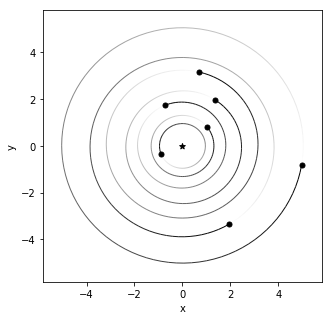

In [26]:
rebound.OrbitPlot(sim)

Period ratios

In [94]:
for i in range(1,7):
    print(ps[i+1].P/ps[i].P)

1.6009208063239937
1.6679113018571639
1.5009741278685107
1.501939182994456
1.335390113399473
1.5037062845692097
